In [12]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import pickle

font = {
        'weight' : 'bold',
        'size'   : 40}

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [9, 5.5]
plt.rcParams['figure.dpi'] = 300
plt.rc('font', **font)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)

GAP_THRESHOLD = 0.4155645340672775, actual gap = 0.4571209874740053
WARNING (OG baseline): og_gamma (41.786696521967656) must in range [0,1]. Decrease # of arms and subset size or Increase # of task
tau < T


In [ ]:
# For E-BASS experiment
# N_TASKS = 400
# N_ARMS = 11
# OPT_SIZE = 2 # >1
# HORIZON = 600

N_TASKS = 1000
N_ARMS = 40
OPT_SIZE = 10 # >1
HORIZON = 1600 #160 for small \tau experiment
N_EXPS = 5 #No. of repeat experiments

GAP_THRESHOLD = np.sqrt(N_ARMS*np.log(N_TASKS)/HORIZON)
gap = min(1,GAP_THRESHOLD*1.1)
kwargs = {
          'gap_constrain':gap, #or None
          'is_adversarial': True,
          'skip_list': ["G_BASS_FC", "EE", "E_BASS"],
          'timeout': 45, # maximum duration for each experiment. Unit = minute. -1 = unlimited
          'quiet': True,
          'linewidth': 7, # plotting parameter
          'plot_legend': True,
          'OG_scale': 1,
          'is_non_oblivious': False,
         }

if kwargs['is_adversarial']:
    setting = "Adversarial"
else:
    setting = "Stochastic"
print(f'GAP_THRESHOLD = {GAP_THRESHOLD}, actual gap = {gap}')
utils.verify_params(N_TASKS, N_ARMS, HORIZON, OPT_SIZE, **kwargs)

## Regret vs Number of tasks

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 48.27it/s]

tau < Ttau < Ttau < Ttau < Ttau < T






WARNING (Phased Elimination): phase 1 duration (1200) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 6.657760223502089
OS_BASS: self.tau_prime = 248, self.gamma = 0.0013414635535754038
WARNING (Phased Elimination): phase 1 duration (1200) is larger than the horizon (160) => increase horizon and/or change n_arms.WARNING (Phased Elimination): phase 1 duration (1200) is larger than the horizon (160) => increase horizon and/or change n_arms.

OG gamma: 6.657760223502089
OG gamma: 6.657760223502089
OS_BASS: self.tau_prime = 248, self.gamma = 0.0013414635535754038
OS_BASS: self.tau_prime = 248, self.gamma = 0.0013414635535754038
WARNING (Phased Elimination): phase 1 duration (1200) is larger than the horizon (160) => increase horizon and/or change n_arms.WARNING (Phased Elimination): phase 1 duration (1200) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 6.657760223502089
OS_BASS: self.tau_prime = 248, self.gamma = 0.

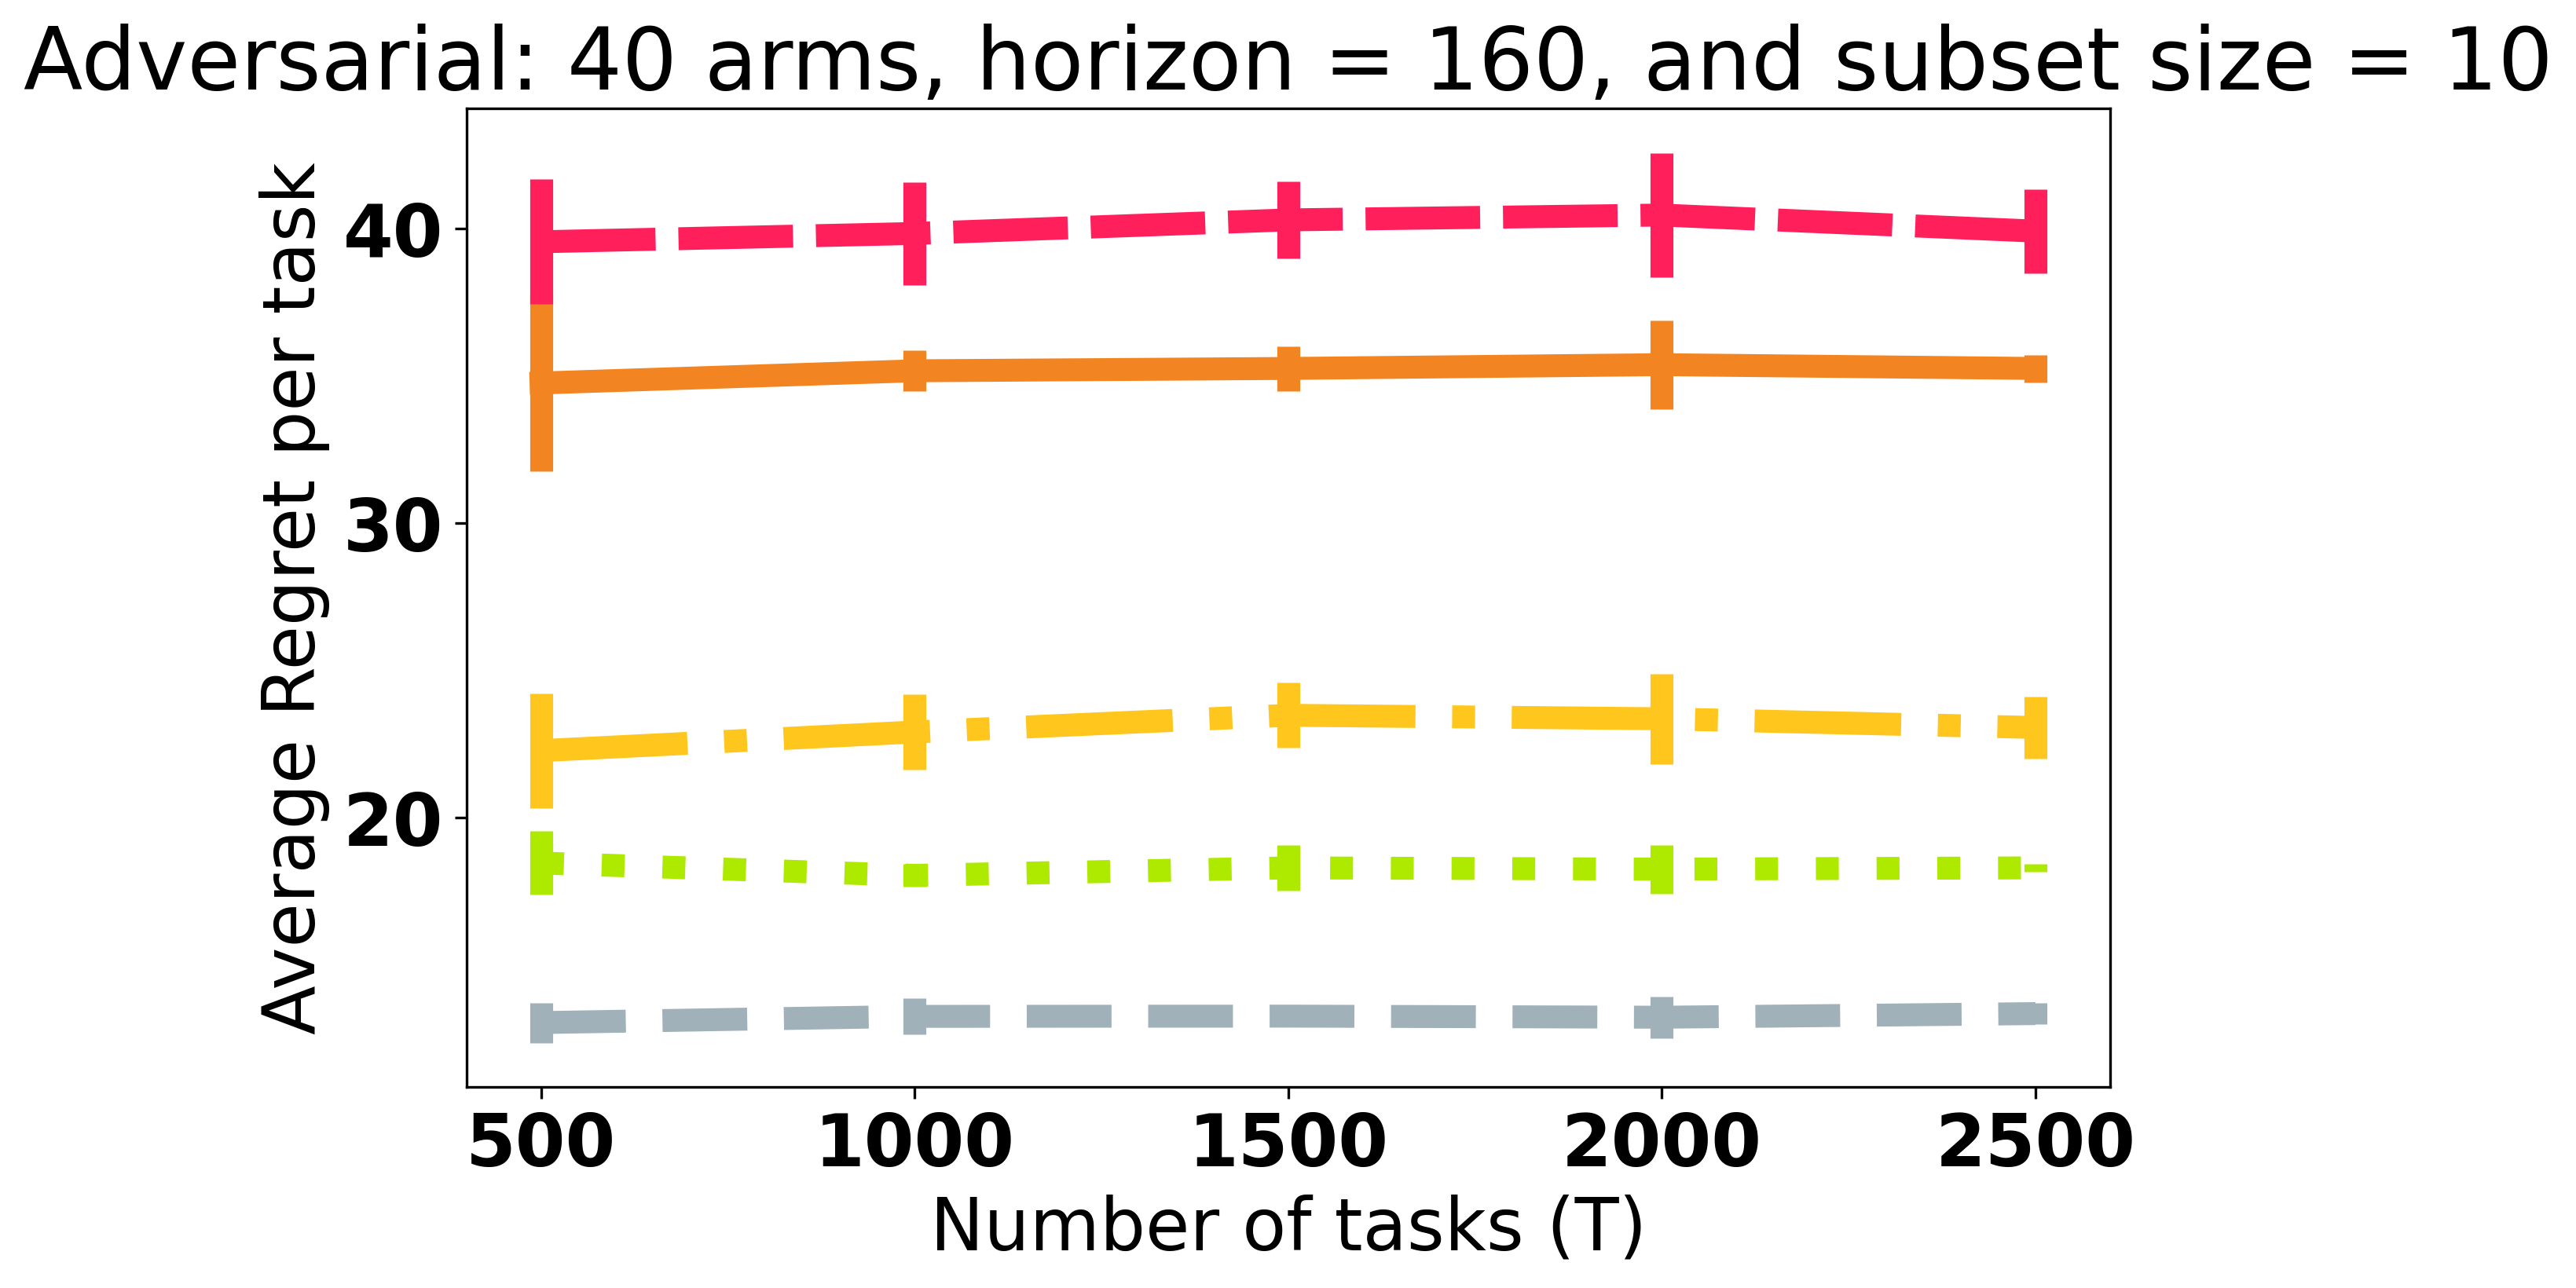

In [7]:
# task_list = np.arange(100, 501, 100)
task_list = np.arange(500, 2501, 500)
(X, regret_dict, title, xlabel, ylabel) = utils.task_exp(N_EXPS, N_ARMS, OPT_SIZE, HORIZON, task_list, **kwargs)
pickle.dump(regret_dict, open("results/tasks.p", "wb"))
pass

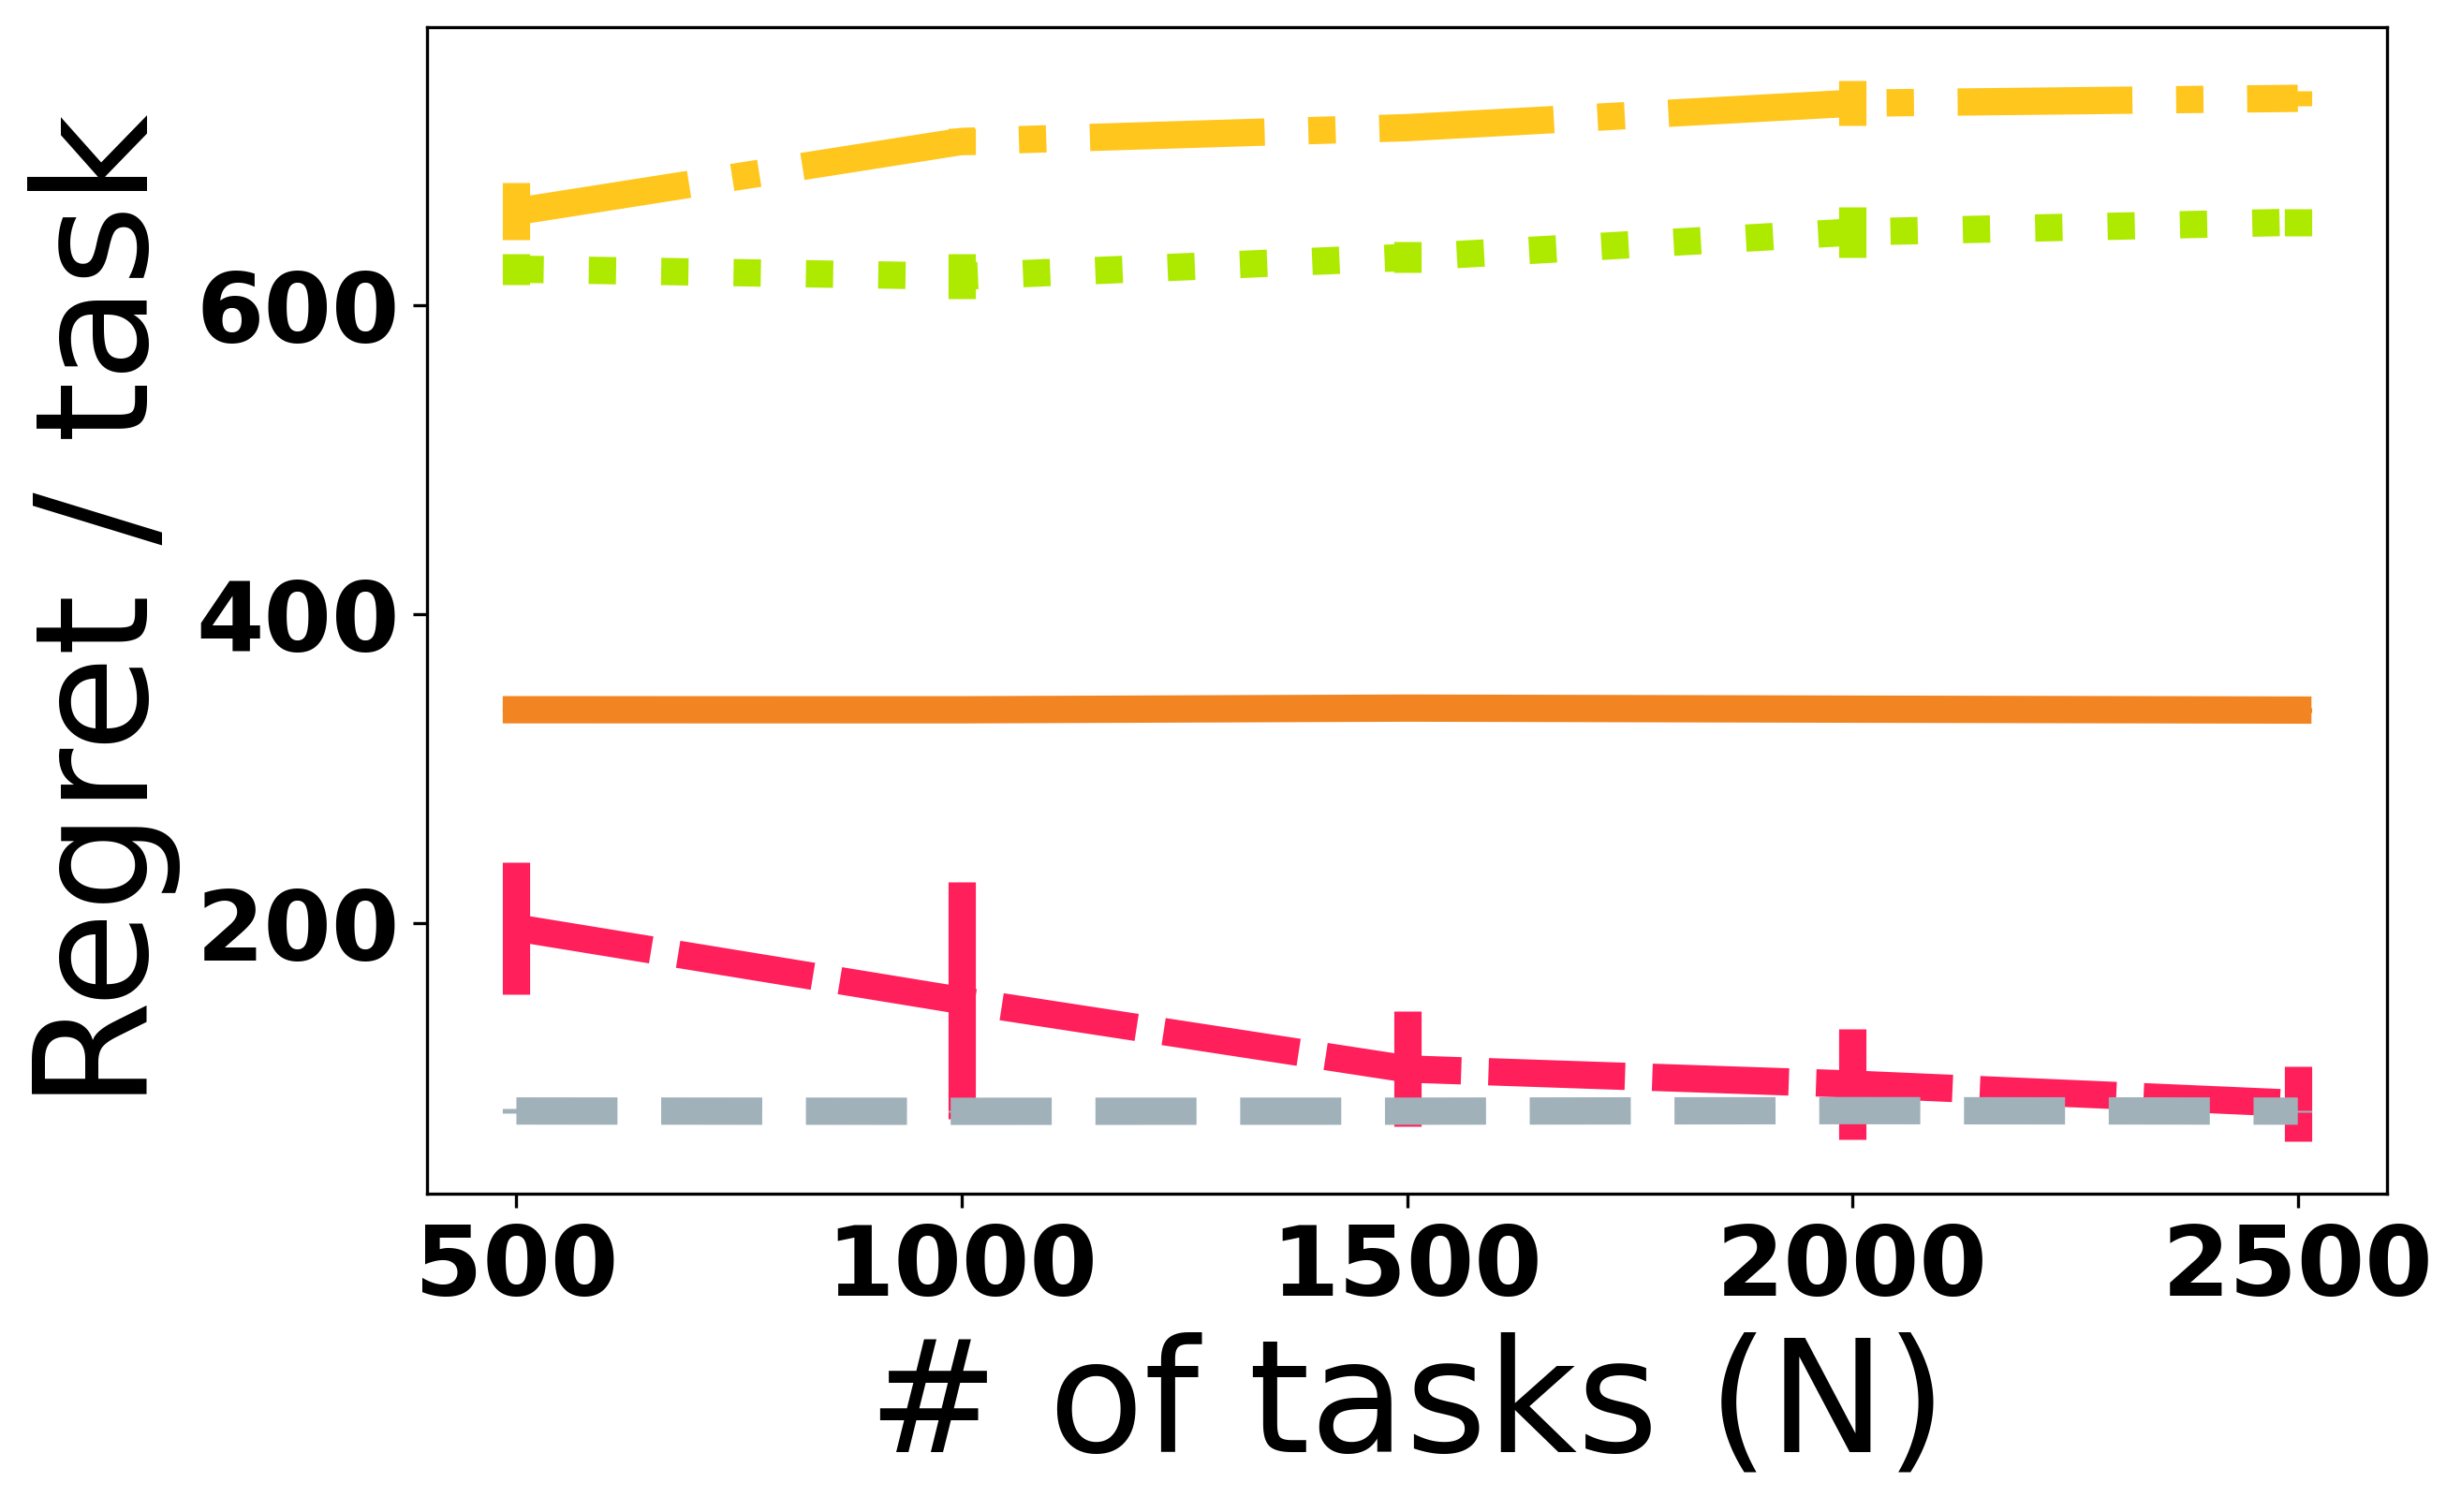

In [43]:
# Plot from loaded cache file
# X = np.arange(100, 501, 100)
X = np.arange(500, 2501, 500)
gap = kwargs['gap_constrain']
regret_dict = pickle.load(open("results/tasks.p", "rb"))
utils.plot(X, regret_dict, '', '# of tasks (N)', 'Regret / task', **kwargs)
pass

## Regret vs Horizon

  0%|                                                     | 0/5 [00:00<?, ?it/s]

tau < T
tau < T
tau < T
tau < T


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 98.09it/s]

tau < T
WARNING (Phased Elimination): phase 1 duration (1280) is larger than the horizon (300) => increase horizon and/or change n_arms.
OG gamma: 5.284267791269626
OS_BASS: self.tau_prime = 422, self.gamma = 0.0009023385200899955
WARNING (Phased Elimination): phase 1 duration (1280) is larger than the horizon (300) => increase horizon and/or change n_arms.WARNING (Phased Elimination): phase 1 duration (1280) is larger than the horizon (300) => increase horizon and/or change n_arms.

OG gamma: 5.284267791269626OG gamma: 5.284267791269626

OS_BASS: self.tau_prime = 422, self.gamma = 0.0009023385200899955
OS_BASS: self.tau_prime = 422, self.gamma = 0.0009023385200899955
WARNING (Phased Elimination): phase 1 duration (1280) is larger than the horizon (300) => increase horizon and/or change n_arms.
OG gamma: 5.284267791269626
OS_BASS: self.tau_prime = 422, self.gamma = 0.0009023385200899955


WARNING (Phased Elimination): phase 1 duration (1280) is larger than the horizon (300) => increase horizon and/or change n_arms.
OG gamma: 5.284267791269626
OS_BASS: self.tau_prime = 422, self.gamma = 0.0009023385200899955
tau < T
WARNING (Phased Elimination): phase 1 duration (1320) is larger than the horizon (350) => increase horizon and/or change n_arms.
OG gamma: 5.284267791269626
OS_BASS: self.tau_prime = 449, self.gamma = 0.000861559867003284
tau < T
WARNING (Phased Elimination): phase 1 duration (1320) is larger than the horizon (350) => increase horizon and/or change n_arms.
OG gamma: 5.284267791269626
OS_BASS: self.tau_prime = 449, self.gamma = 0.000861559867003284
tau < T
WARNING (Phased Elimination): phase 1 duration (1320) is larger than the horizon (350) => increase horizon and/or change n_arms.
OG gamma: 5.284267791269626
OS_BASS: self.tau_prime = 449, self.gamma = 0.000861559867003284
tau < T
WARNING (Phased Elimination): phase 1 duration (1320) is larger than the horizo

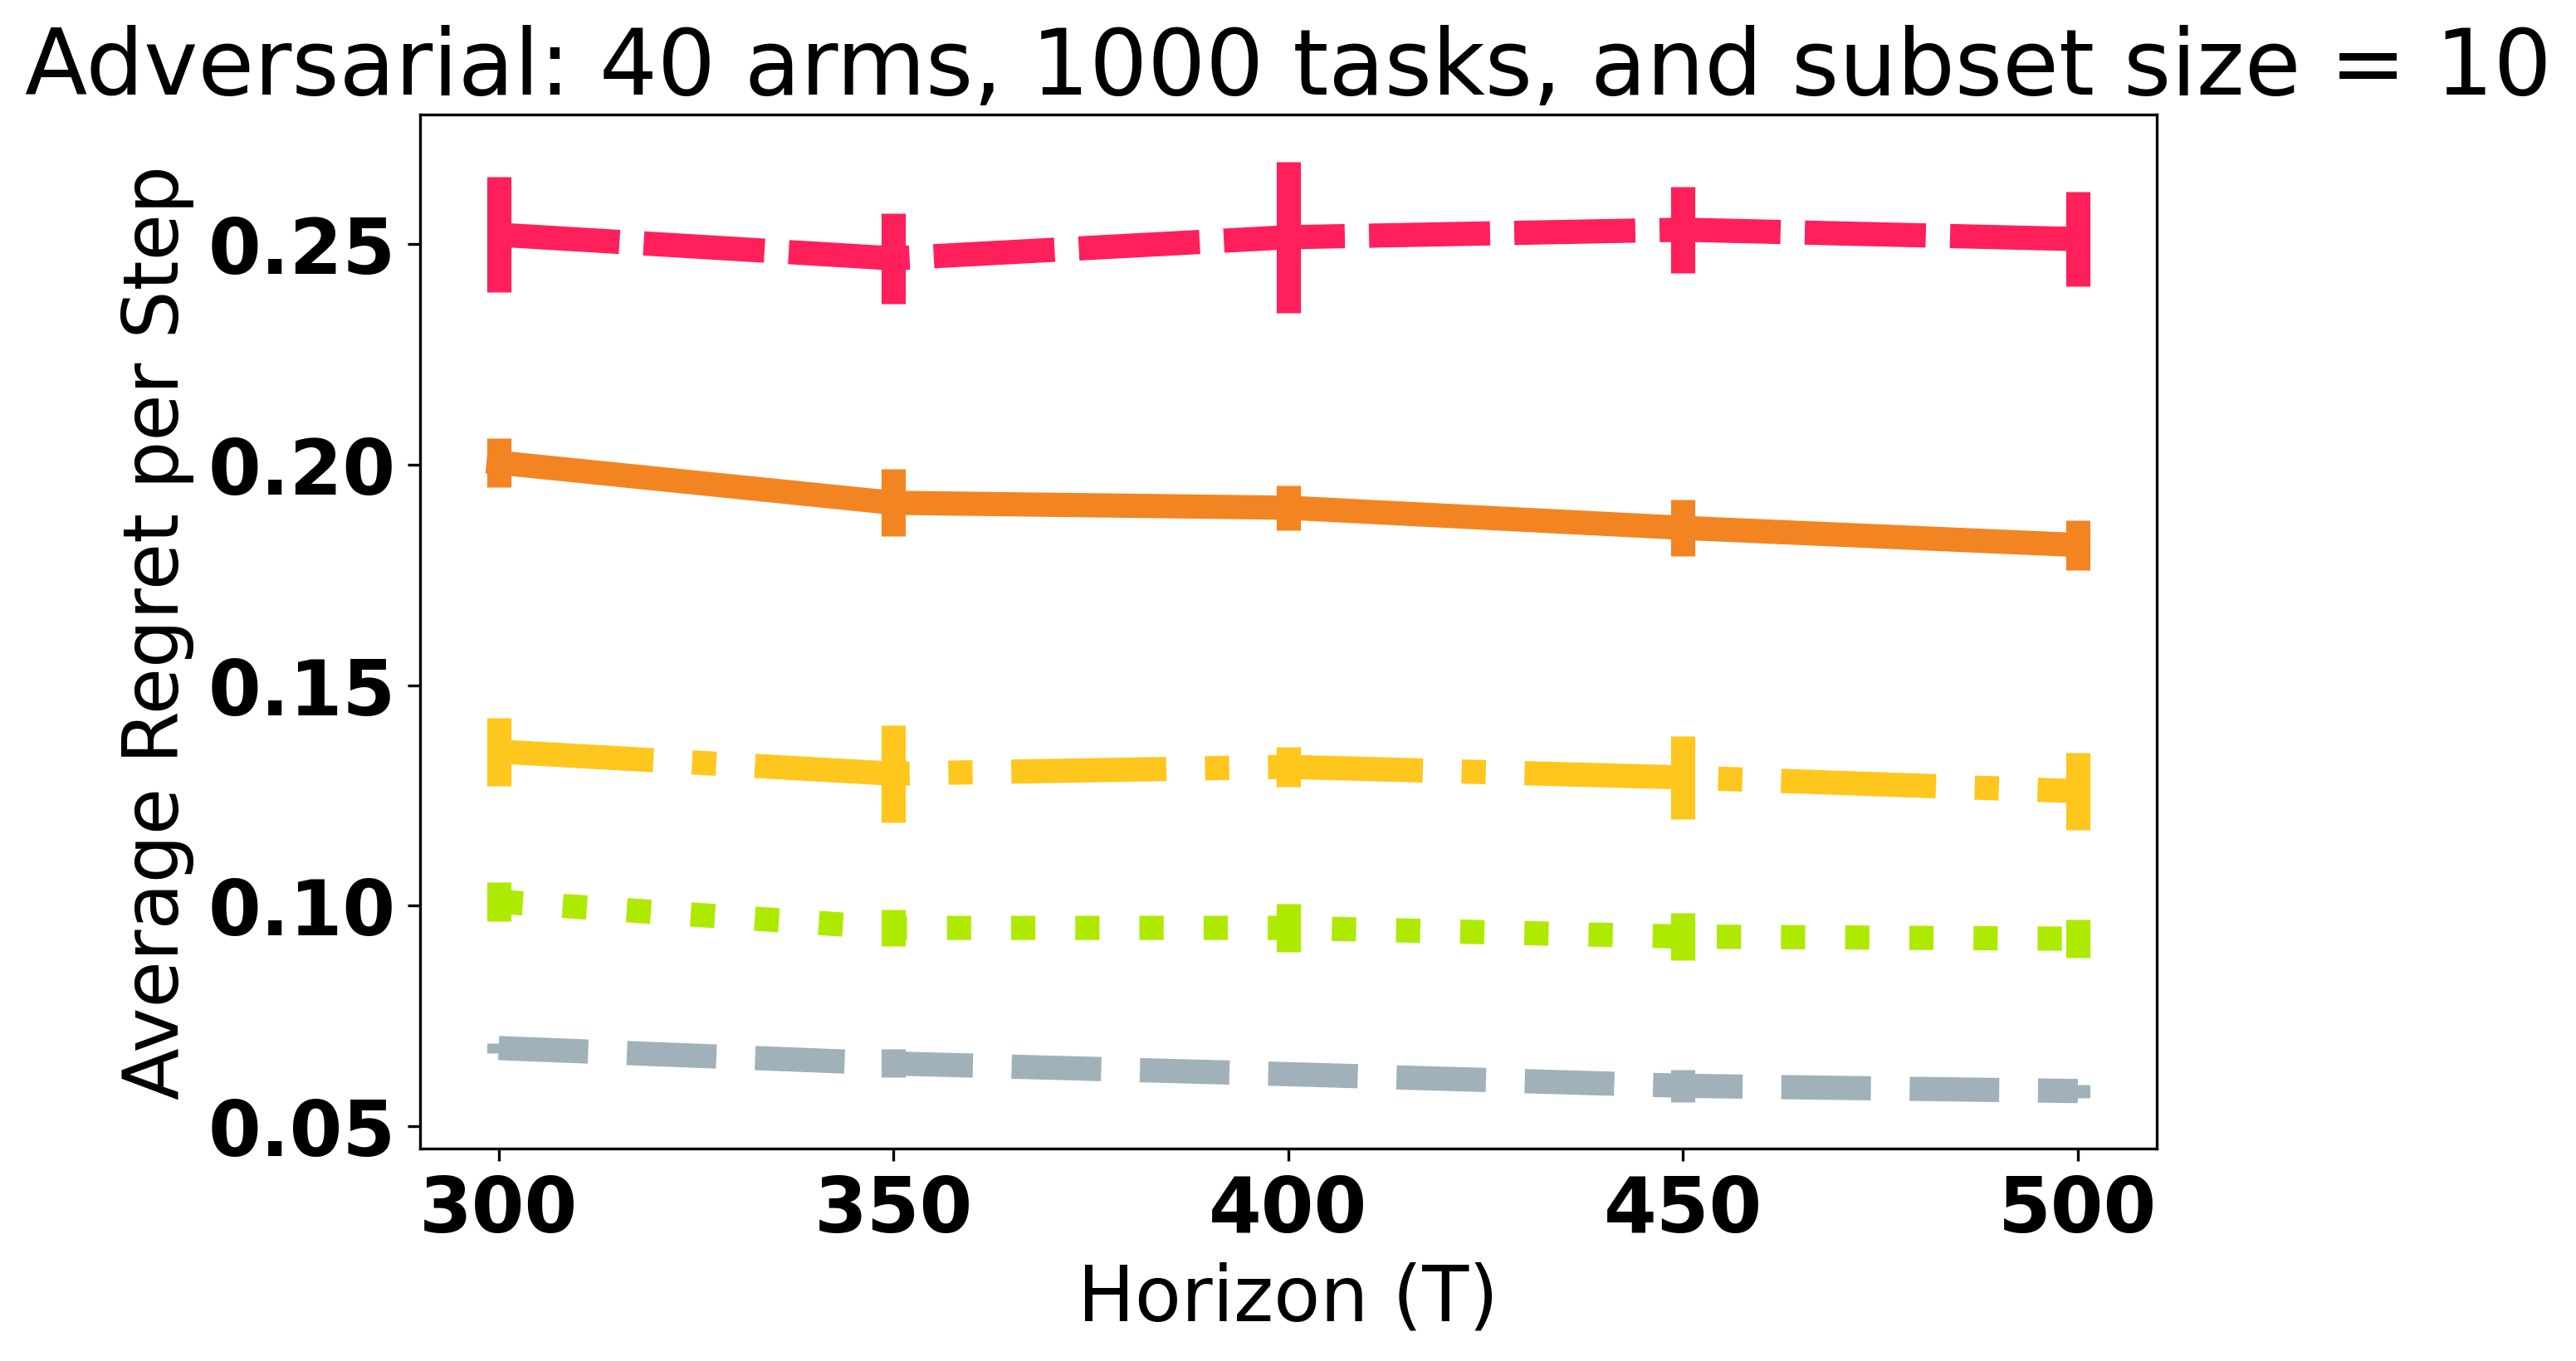

In [10]:
# horizon_list = np.arange(300, 506, 50)
horizon_list = np.arange(1600, 3606, 500)
(X_h, regret_dict_h, title, xlabel, ylabel) = \
utils.horizon_exp(N_EXPS, N_TASKS, N_ARMS, OPT_SIZE, 
                  horizon_list = horizon_list, **kwargs)
pickle.dump(regret_dict_h, open("results/horizon.p", "wb"))
pass

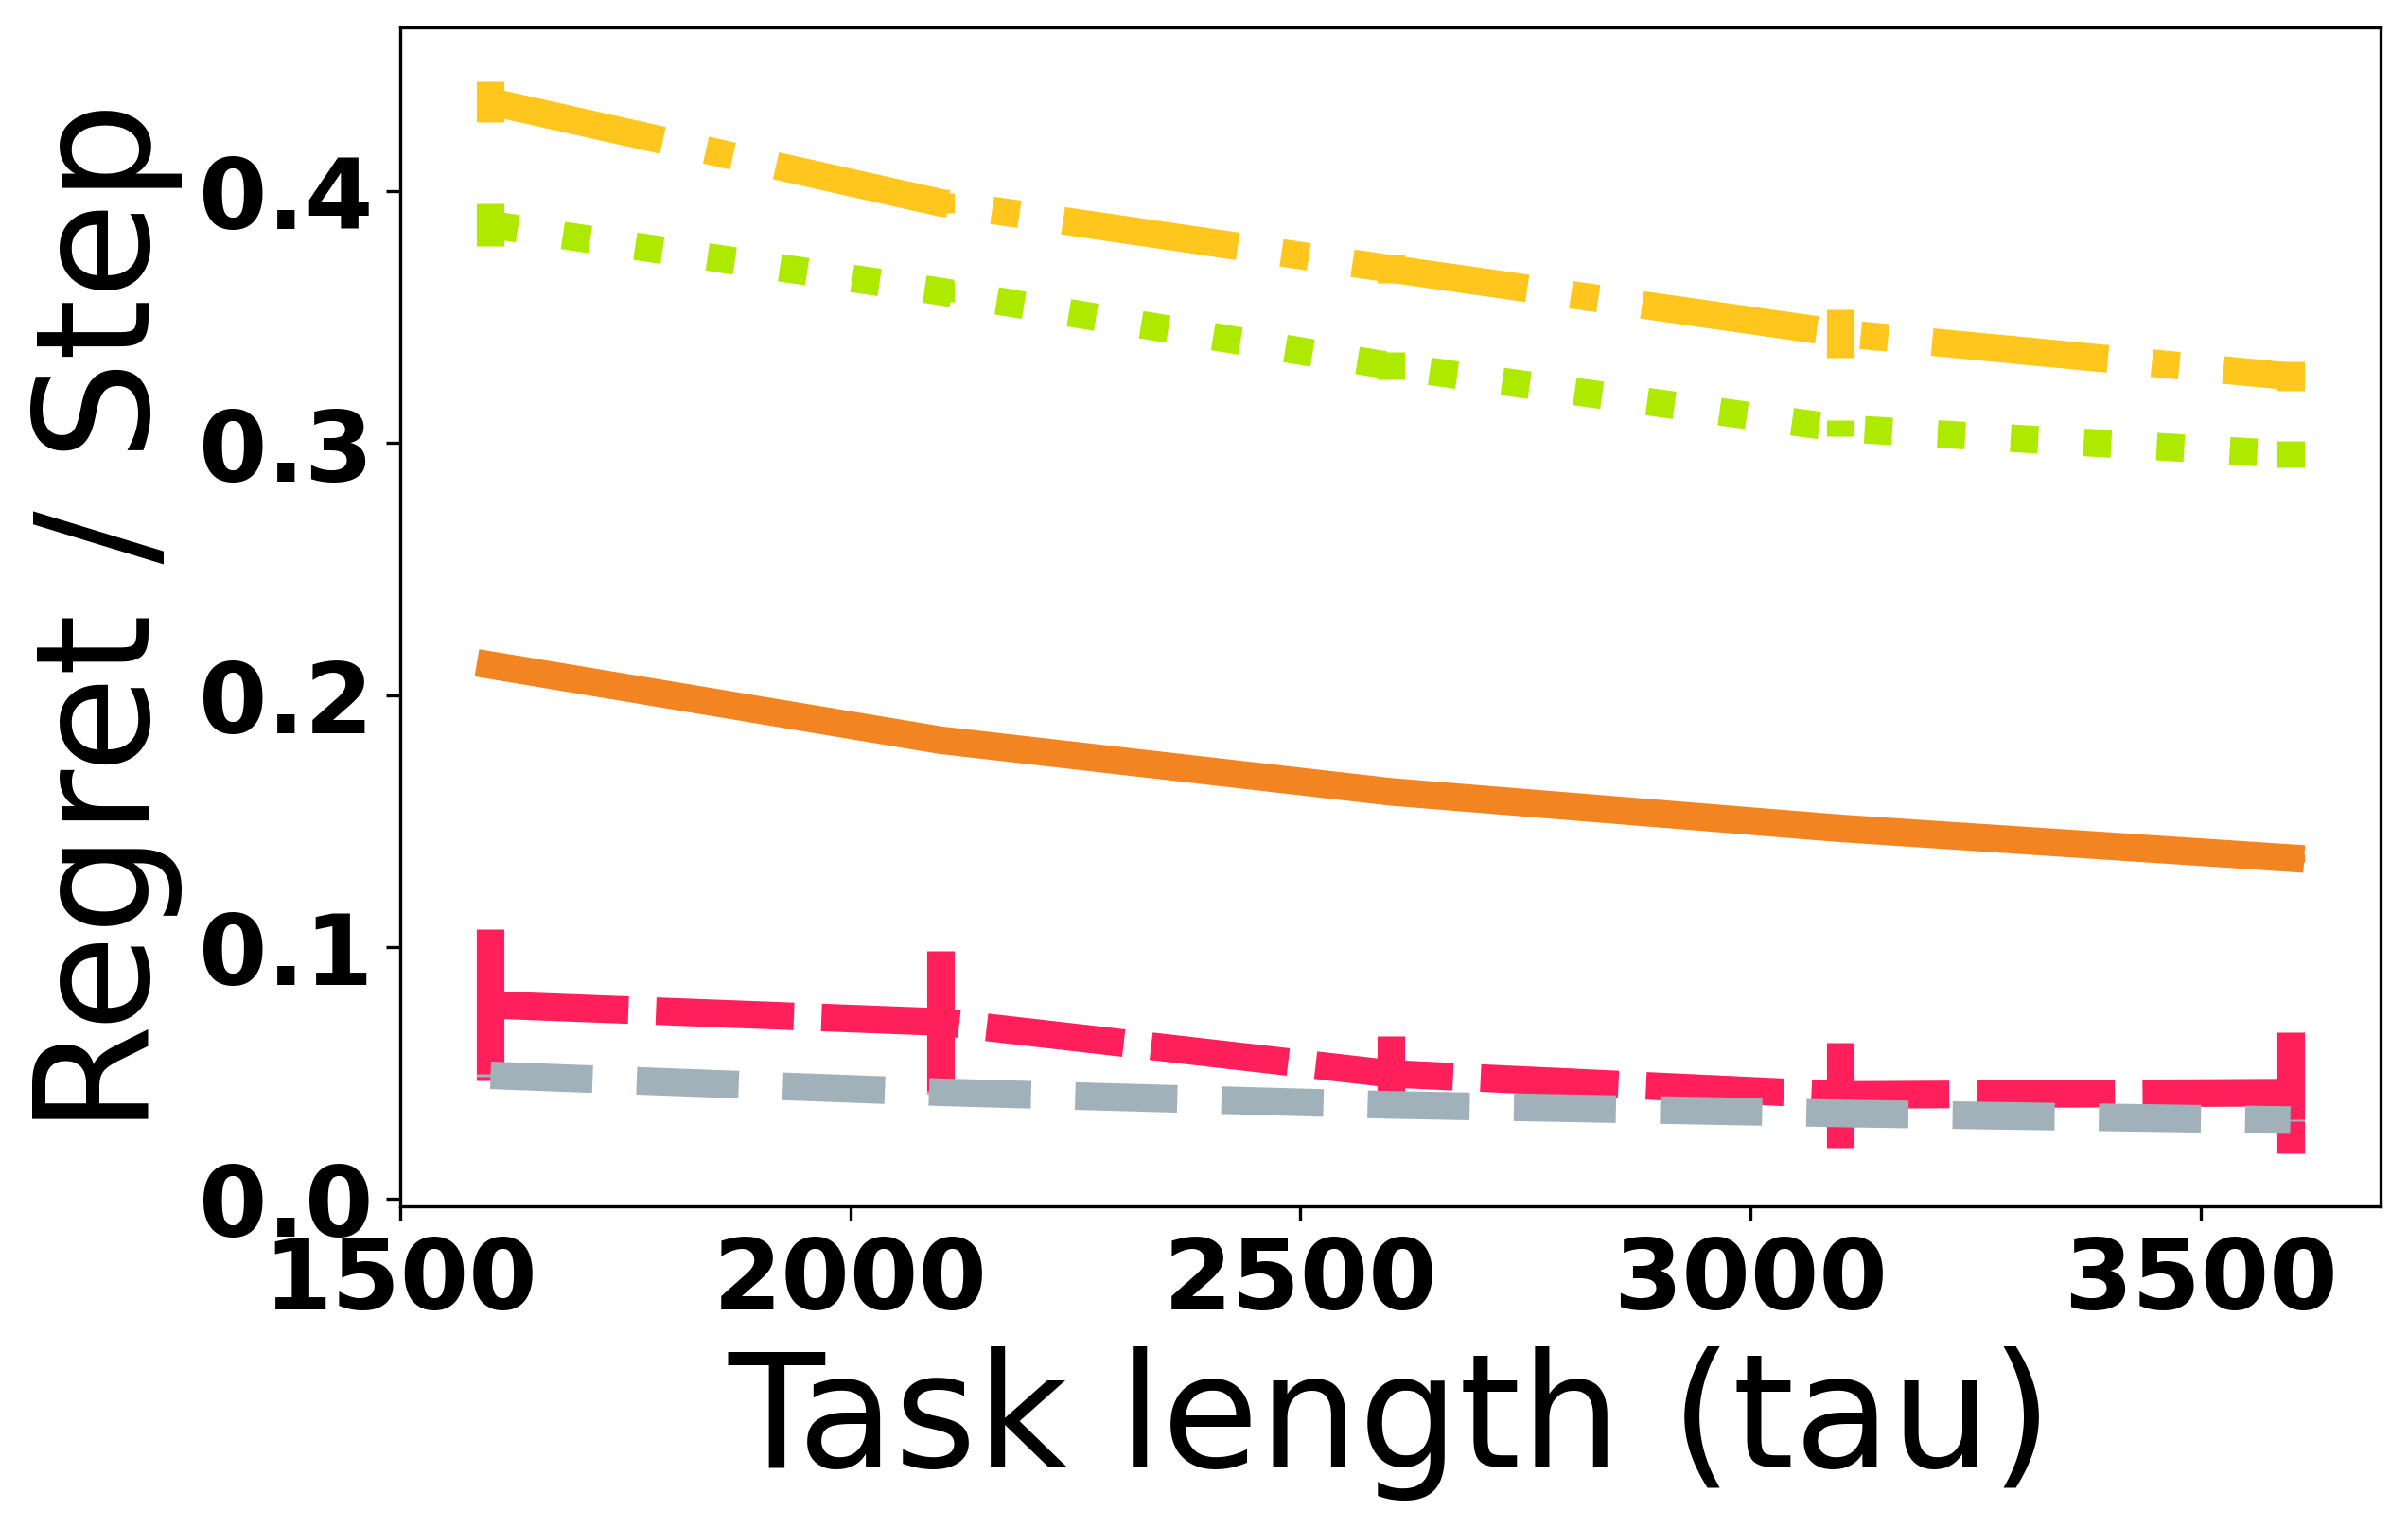

In [44]:
# Plot from loaded cache file
# X_h = np.arange(300, 506, 50)
X_h = np.arange(1600, 3606, 500)
regret_dict_h = pickle.load(open("results/horizon.p", "rb"))
utils.plot(X_h, regret_dict_h, '', 'Task length (tau)', 'Regret / Step', **kwargs)
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

## Regret vs # of arm

  0%|                                                     | 0/5 [00:00<?, ?it/s]

tau < T
tau < T
tau < Ttau < T

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 125.63it/s]



tau < T
WARNING (Phased Elimination): phase 1 duration (540) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 3.9130103619430816
OS_BASS: self.tau_prime = 433, self.gamma = 0.002255849599008625
WARNING (Phased Elimination): phase 1 duration (540) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 3.9130103619430816
OS_BASS: self.tau_prime = 433, self.gamma = 0.002255849599008625
WARNING (Phased Elimination): phase 1 duration (540) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 3.9130103619430816
OS_BASS: self.tau_prime = 433, self.gamma = 0.002255849599008625
WARNING (Phased Elimination): phase 1 duration (540) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 3.9130103619430816
OS_BASS: self.tau_prime = 433, self.gamma = 0.002255849599008625
WARNING (Phased Elimination): phase 1 duration (540) is larger than the horizon (160) => increase hori


OG gamma: 3.9130103619430816
OS_BASS: self.tau_prime = 433, self.gamma = 0.002255849599008625
tau < T
WARNING (Phased Elimination): phase 1 duration (700) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 4.317325011873595
OS_BASS: self.tau_prime = 396, self.gamma = 0.001789034592375422
tau < T
tau < T
tau < T
WARNING (Phased Elimination): phase 1 duration (700) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 4.317325011873595
OS_BASS: self.tau_prime = 396, self.gamma = 0.001789034592375422WARNING (Phased Elimination): phase 1 duration (700) is larger than the horizon (160) => increase horizon and/or change n_arms.

OG gamma: 4.317325011873595
OS_BASS: self.tau_prime = 396, self.gamma = 0.001789034592375422
WARNING (Phased Elimination): phase 1 duration (700) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 4.317325011873595
OS_BASS: self.tau_prime = 396, self.gamma = 0.00178903

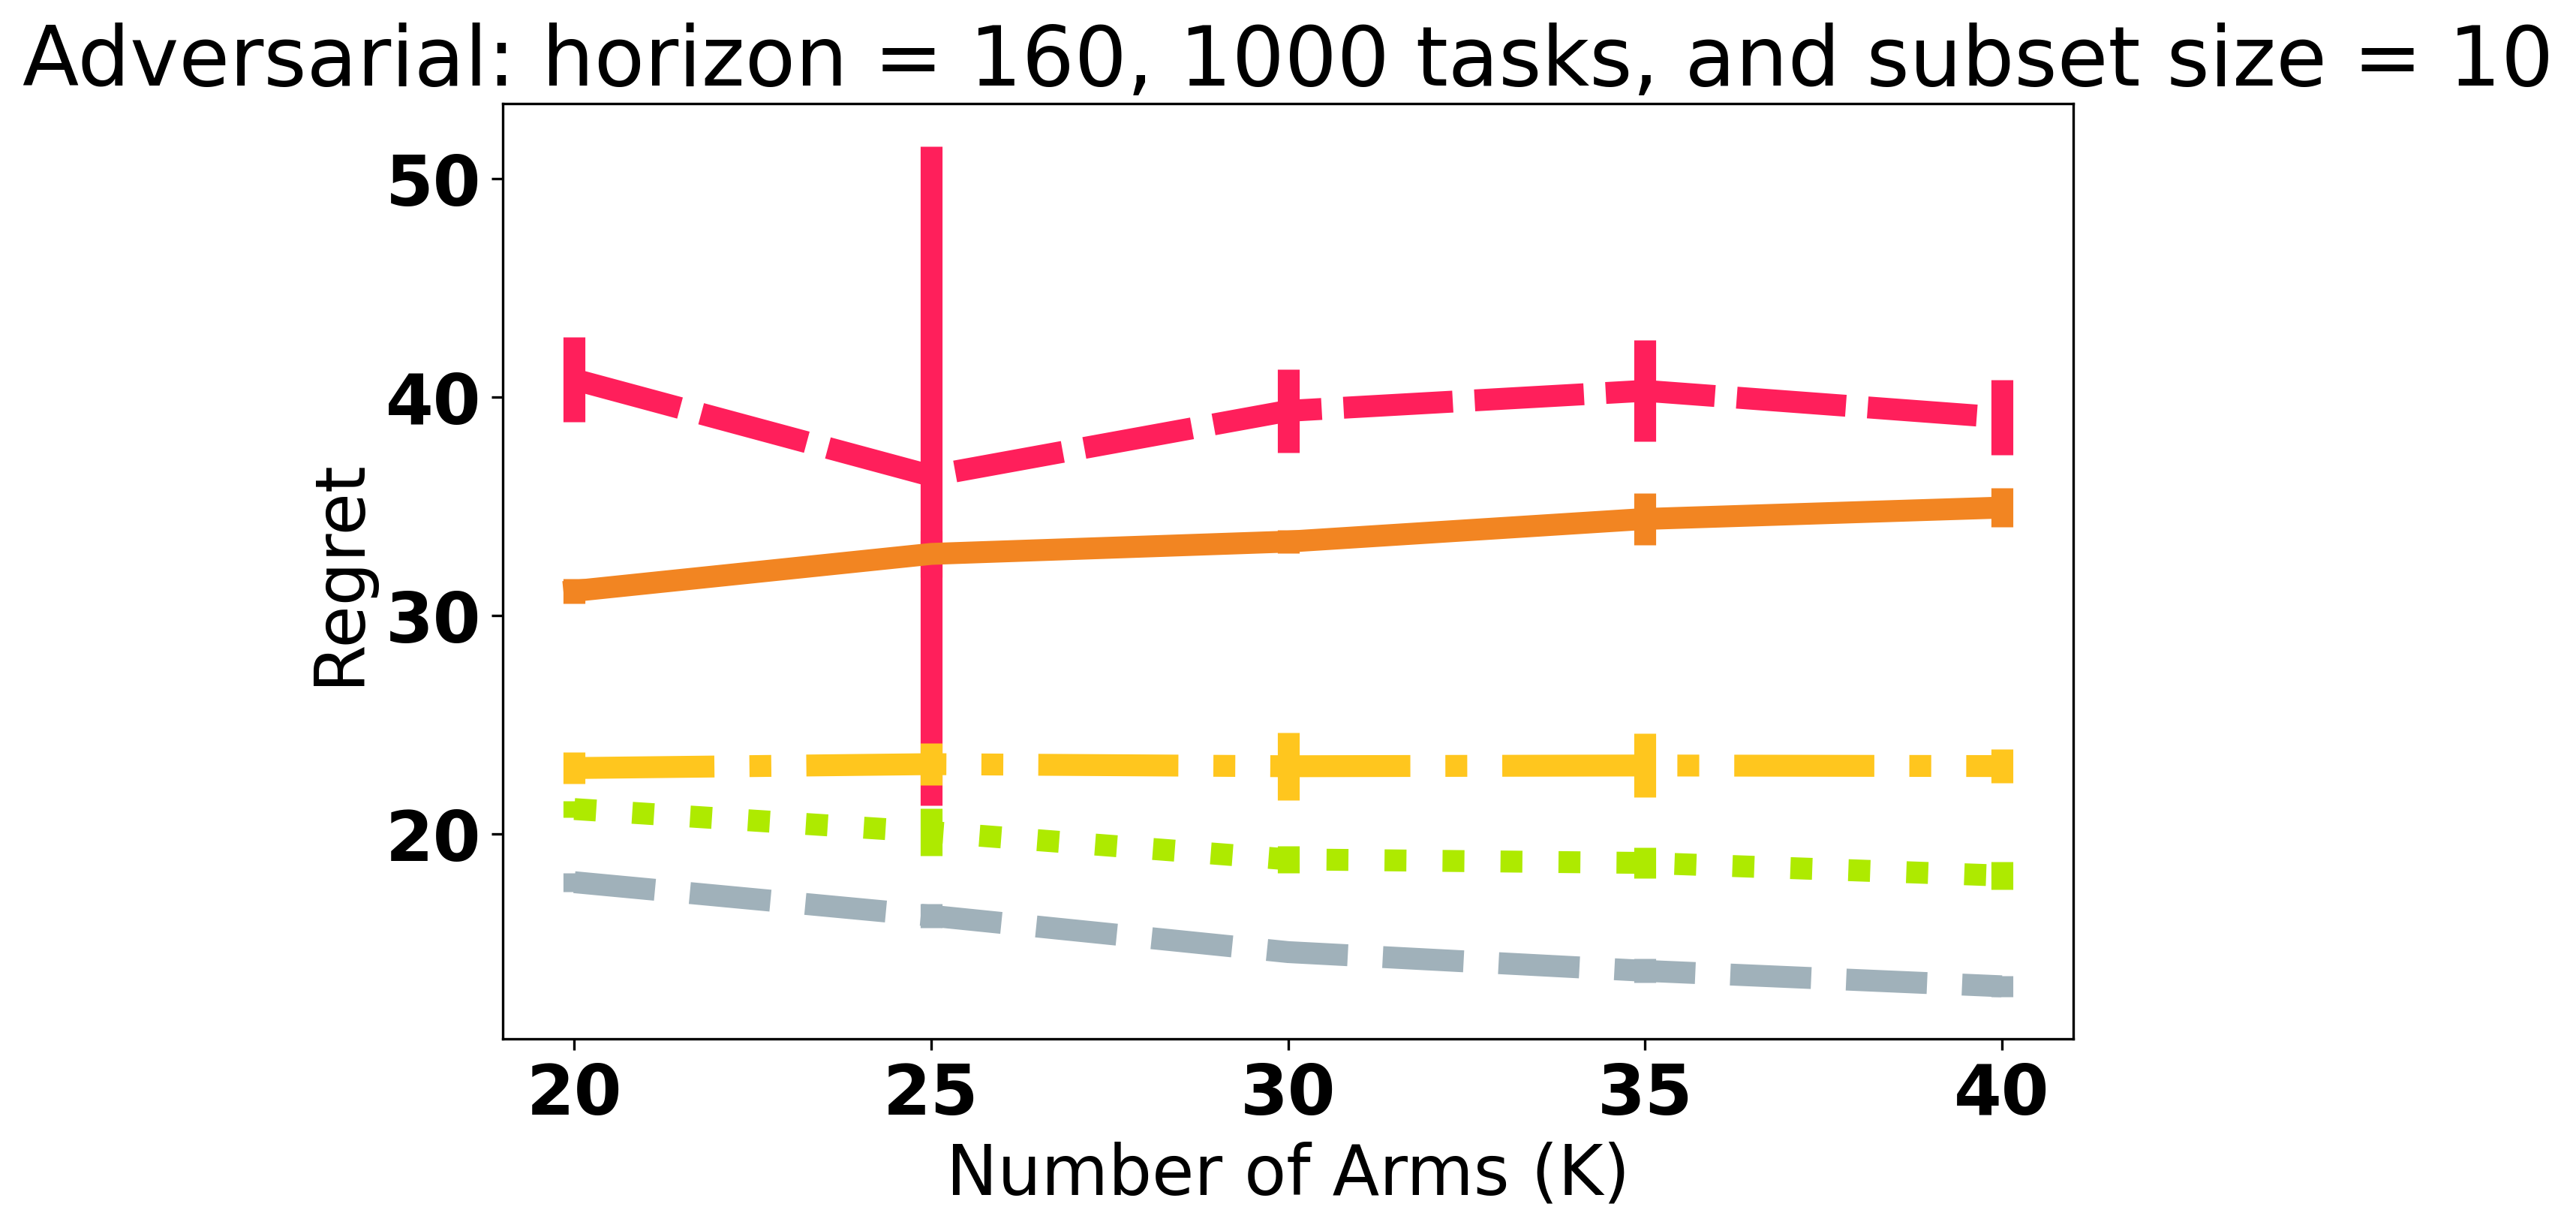

In [8]:
# n_arms_list = np.arange(10,19,2)
n_arms_list = np.arange(20,41,5)
(X_b, regret_dict_b, title, xlabel, ylabel) = \
utils.arms_exp(N_EXPS, N_TASKS, OPT_SIZE, HORIZON, n_arms_list, **kwargs)
pickle.dump(regret_dict_b, open("results/arms.p", "wb"))
pass

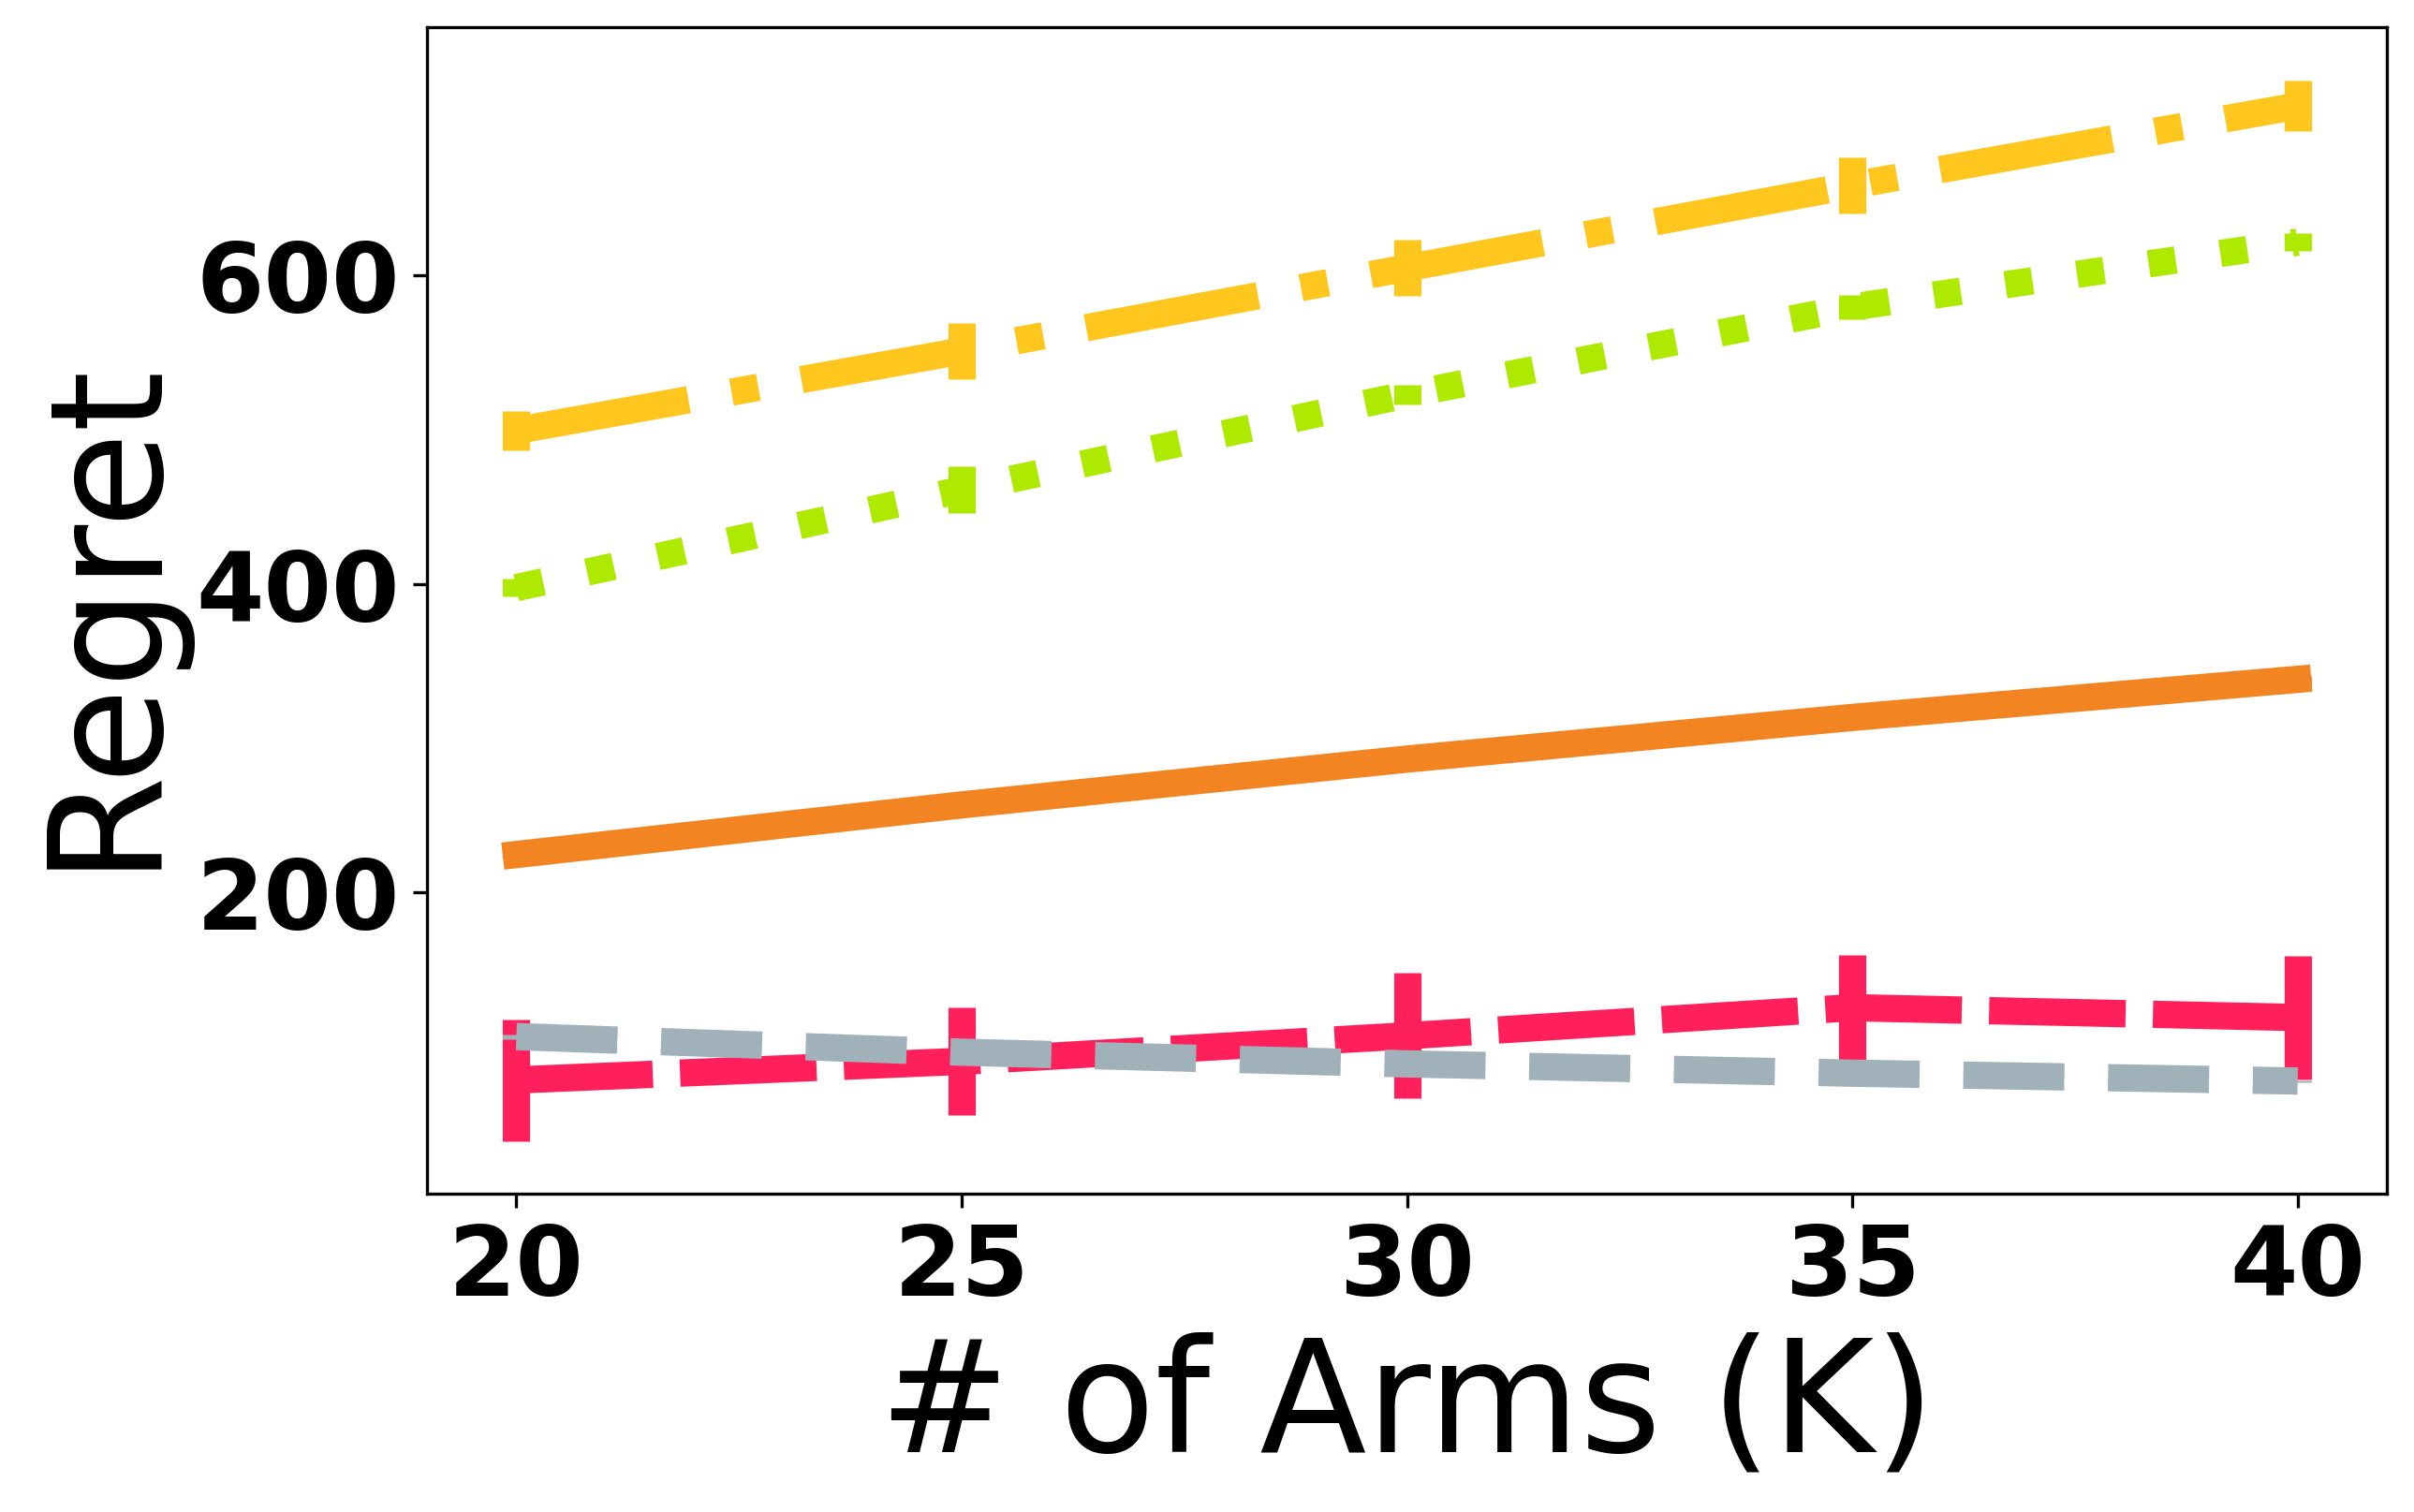

In [45]:
# Plot from loaded cache file
# X_b = np.arange(10,19,2)
X_b = np.arange(20,41,5)
regret_dict_b = pickle.load(open("results/arms.p", "rb"))
utils.plot(X_b, regret_dict_b, '', '# of Arms (K)', 'Regret', **kwargs)

## Regret vs subset size

  0%|                                                     | 0/5 [00:00<?, ?it/s]

tau < T
tau < T
tau < T
tau < T


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 95.87it/s]

tau < T
WARNING (Phased Elimination): phase 1 duration (1200) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 2.1137071165078503
OS_BASS: self.tau_prime = 189, self.gamma = 0.000827728438160742
WARNING (Phased Elimination): phase 1 duration (1200) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 2.1137071165078503
OS_BASS: self.tau_prime = 189, self.gamma = 0.000827728438160742
WARNING (Phased Elimination): phase 1 duration (1200) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 2.1137071165078503
OS_BASS: self.tau_prime = 189, self.gamma = 0.000827728438160742
WARNING (Phased Elimination): phase 1 duration (1200) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 2.1137071165078503


WARNING (Phased Elimination): phase 1 duration (1200) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 2.1137071165078503
OS_BASS: self.tau_prime = 189, self.gamma = 0.000827728438160742
OS_BASS: self.tau_prime = 189, self.gamma = 0.000827728438160742
tau < T
WARNING (Phased Elimination): phase 1 duration (1200) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 3.698987453888738
OS_BASS: self.tau_prime = 265, self.gamma = 0.0009790374192743772
tau < T
WARNING (Phased Elimination): phase 1 duration (1200) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 3.698987453888738
OS_BASS: self.tau_prime = 265, self.gamma = 0.0009790374192743772
tau < T
WARNING (Phased Elimination): phase 1 duration (1200) is larger than the horizon (160) => increase horizon and/or change n_arms.
OG gamma: 3.698987453888738
OS_BASS: self.tau_prime = 265, self.gamma = 0.0009790374192743772
tau < T
WARNING (Ph

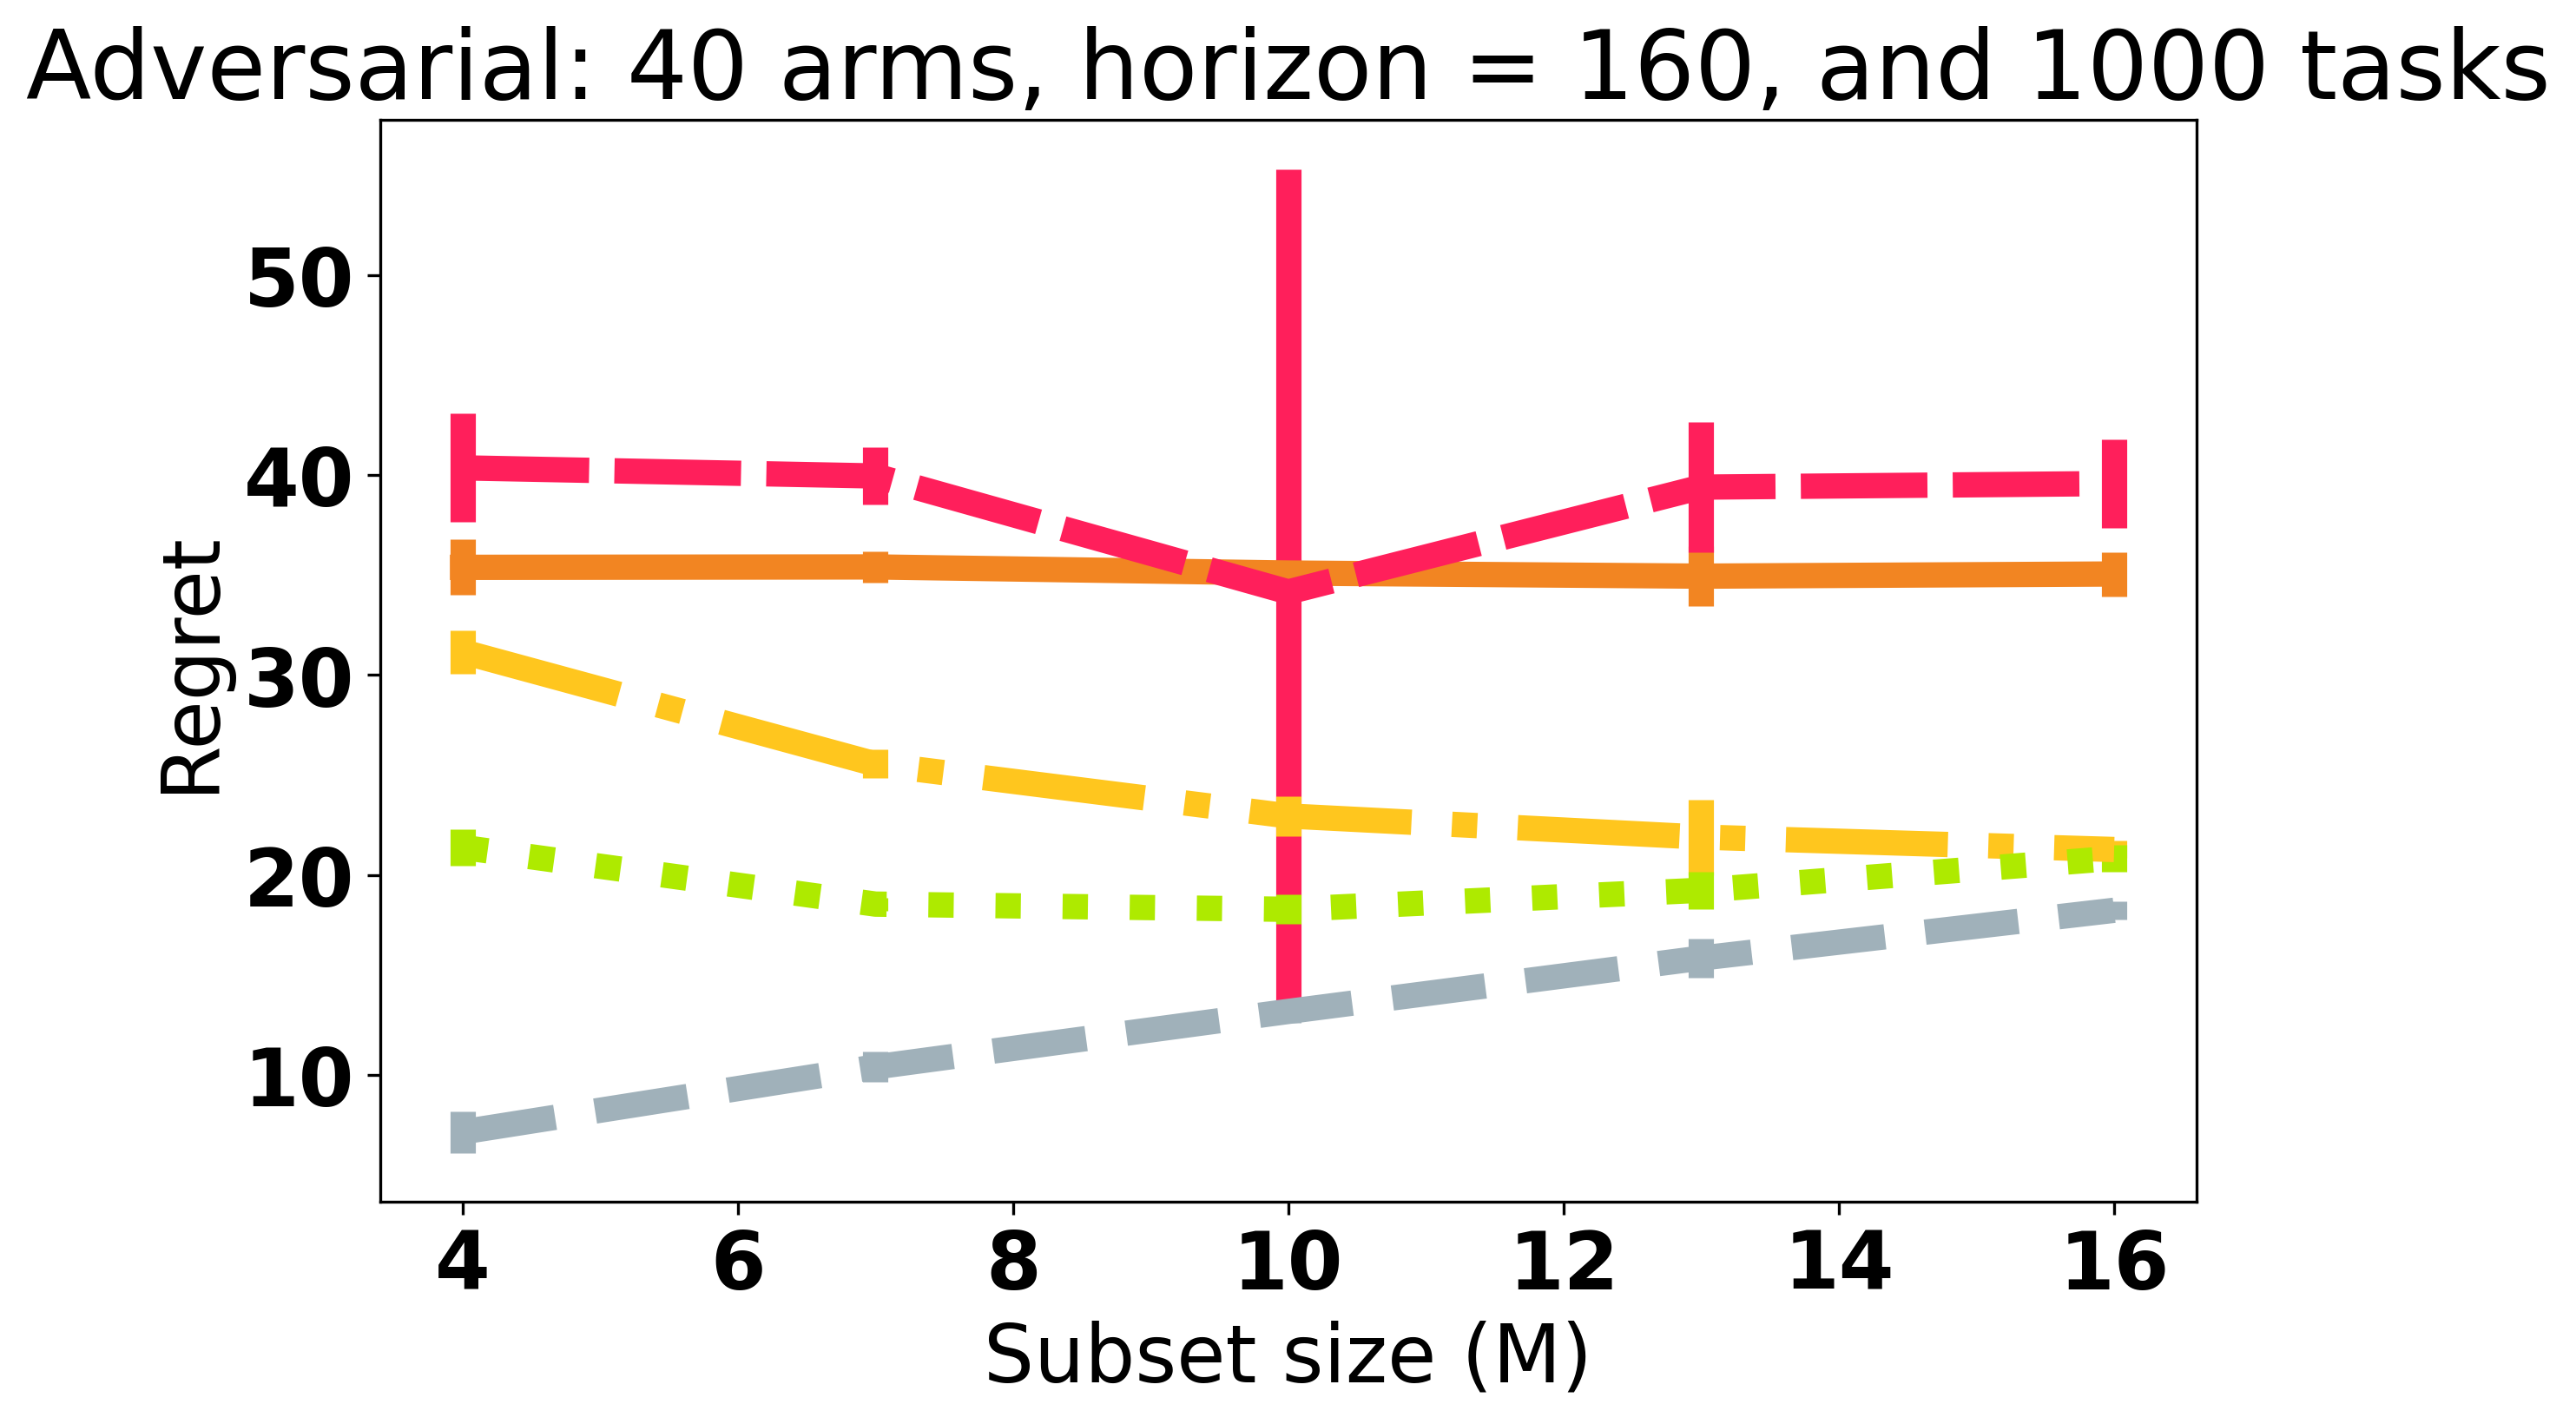

In [9]:
# opt_size_list = np.arange(2,11,2)
opt_size_list = np.arange(4,21,3)
(X_e, regret_dict_e, title, xlabel, ylabel) = utils.subset_exp(N_EXPS, 
                                  N_TASKS, N_ARMS, HORIZON, 
                                  opt_size_list = opt_size_list, **kwargs)
pickle.dump(regret_dict_e, open("results/subset.p", "wb"))
pass

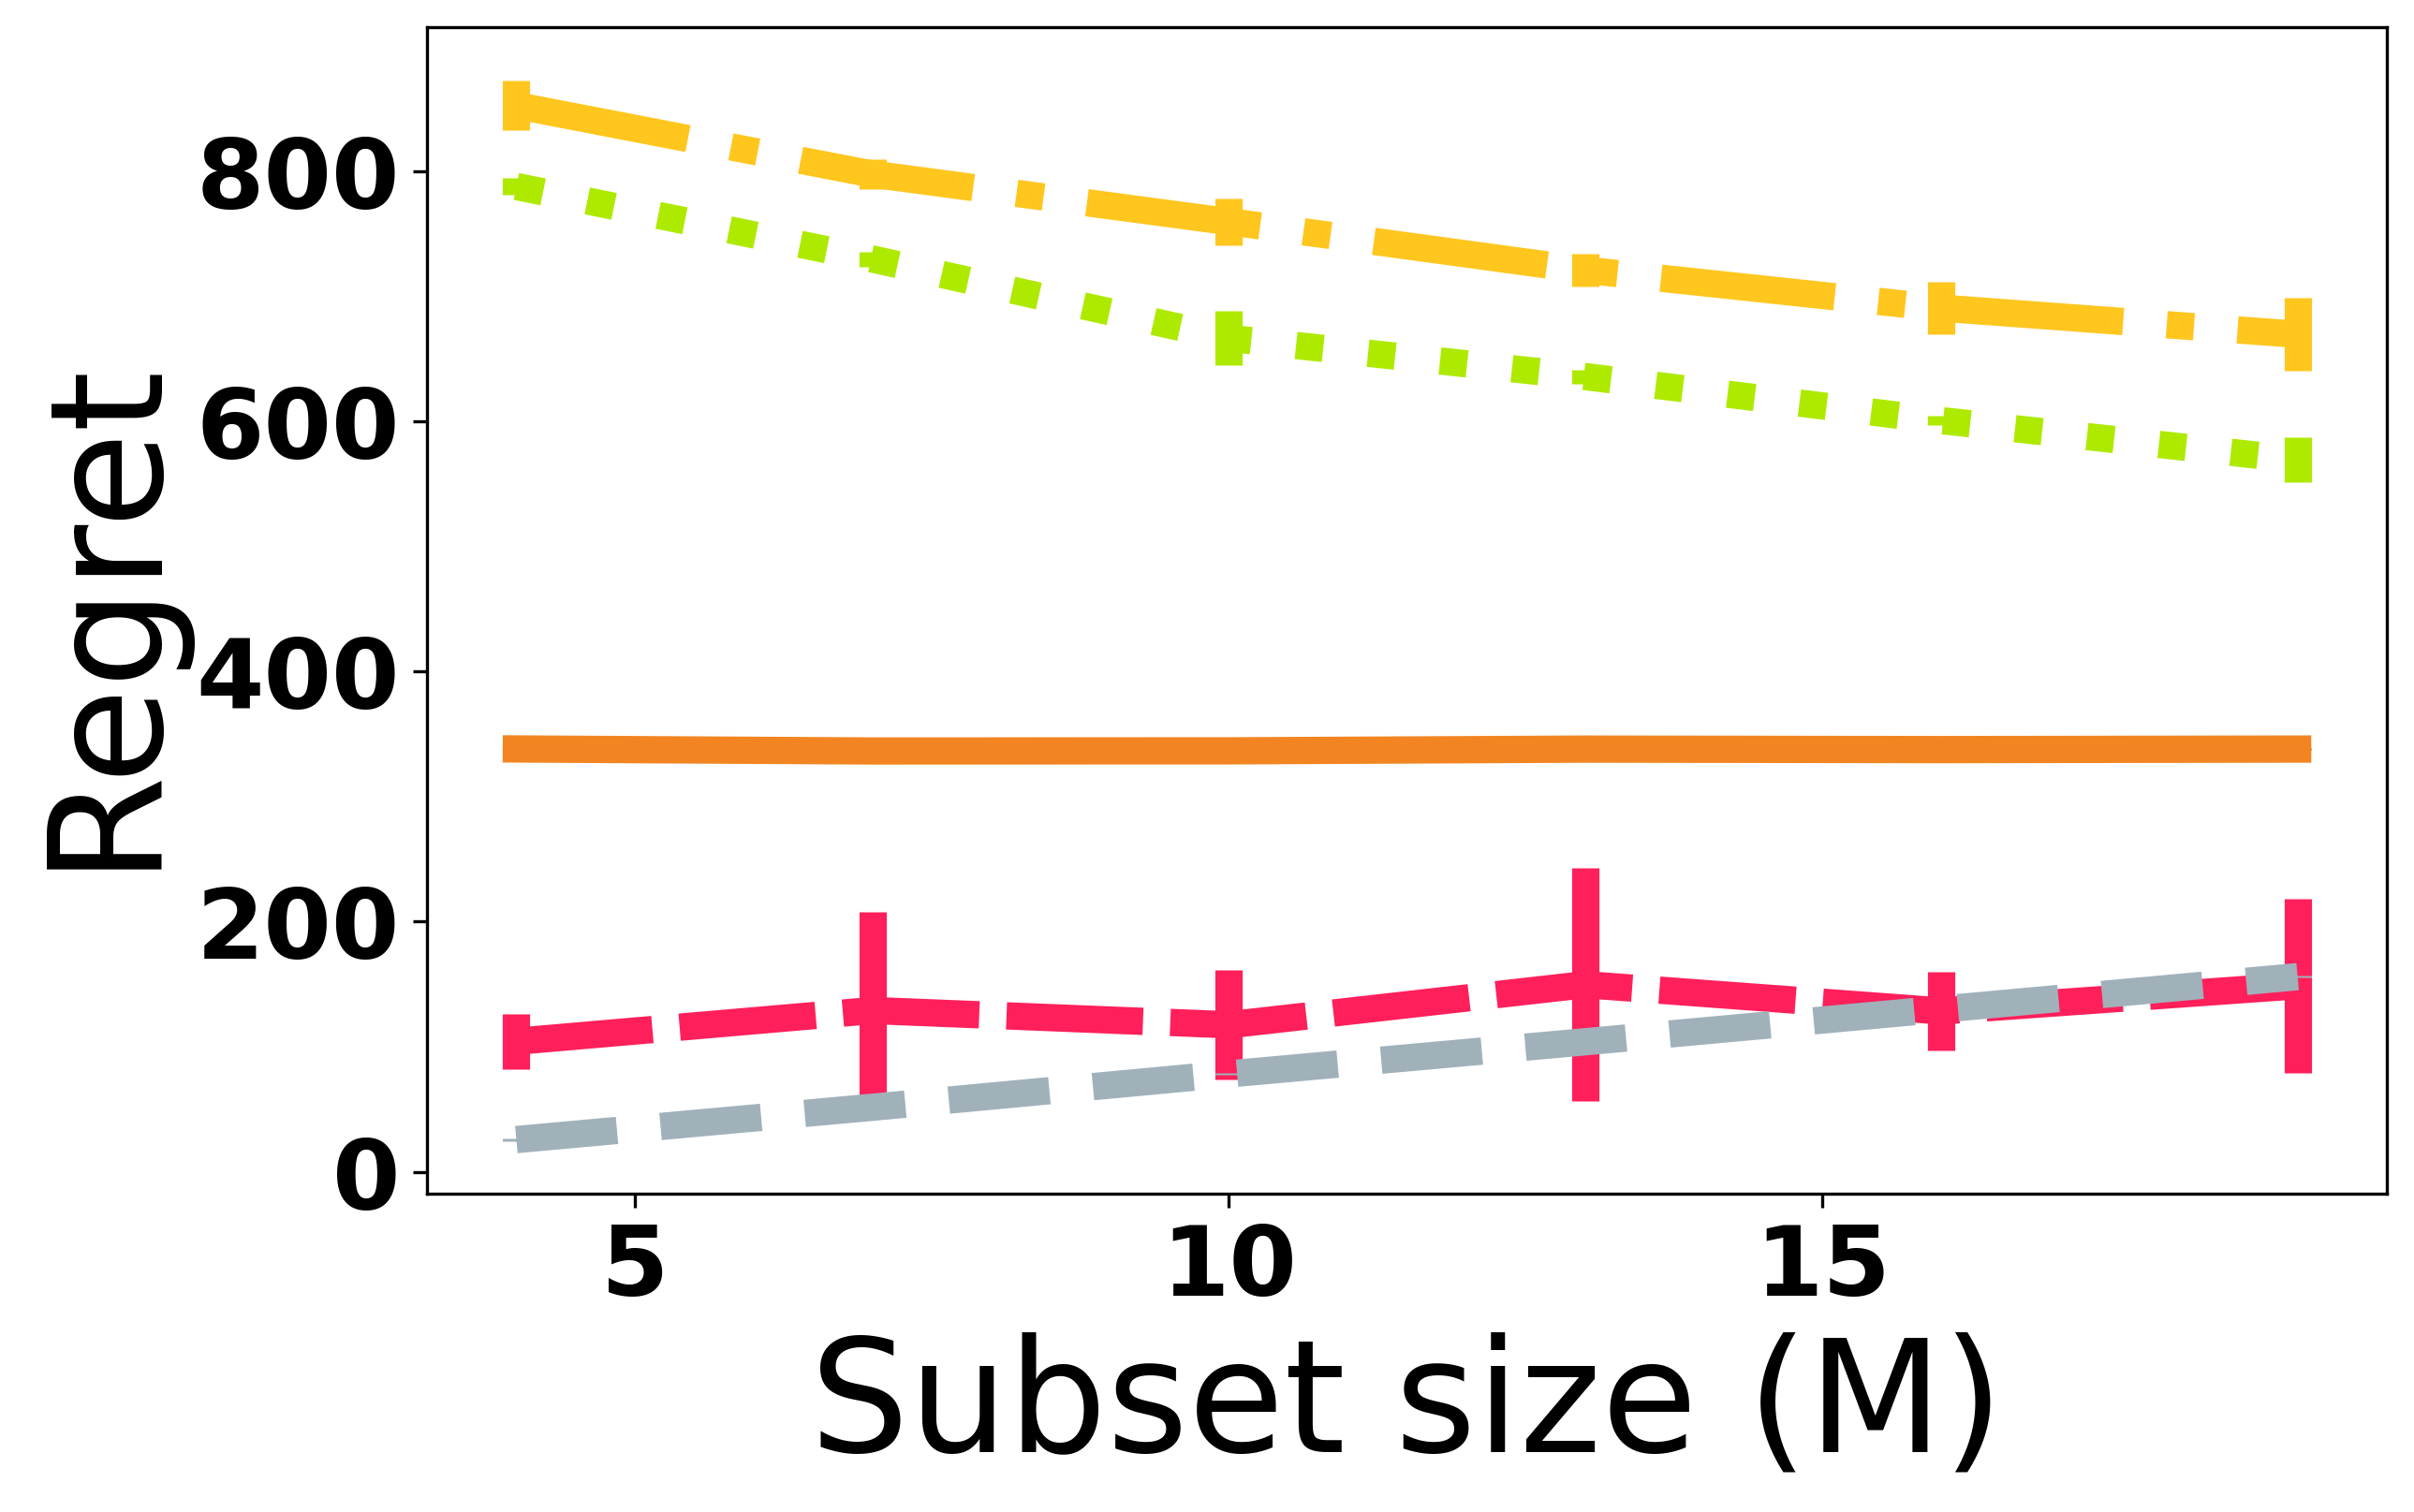

In [46]:
# Plot from loaded cache file
# X_e = np.arange(2,11,2)
X_e = np.arange(4,21,3)
regret_dict_e = pickle.load(open("results/subset.p", "rb"))
utils.plot(X_e, regret_dict_e, '', 'Subset size (M)', 'Regret', **kwargs)

# Plotting legend code

In [2]:
font = {
        'weight' : 'bold',
        'size'   : 6}

plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['figure.figsize'] = [9, 5.5] # NIPS format: [9, 5.5]

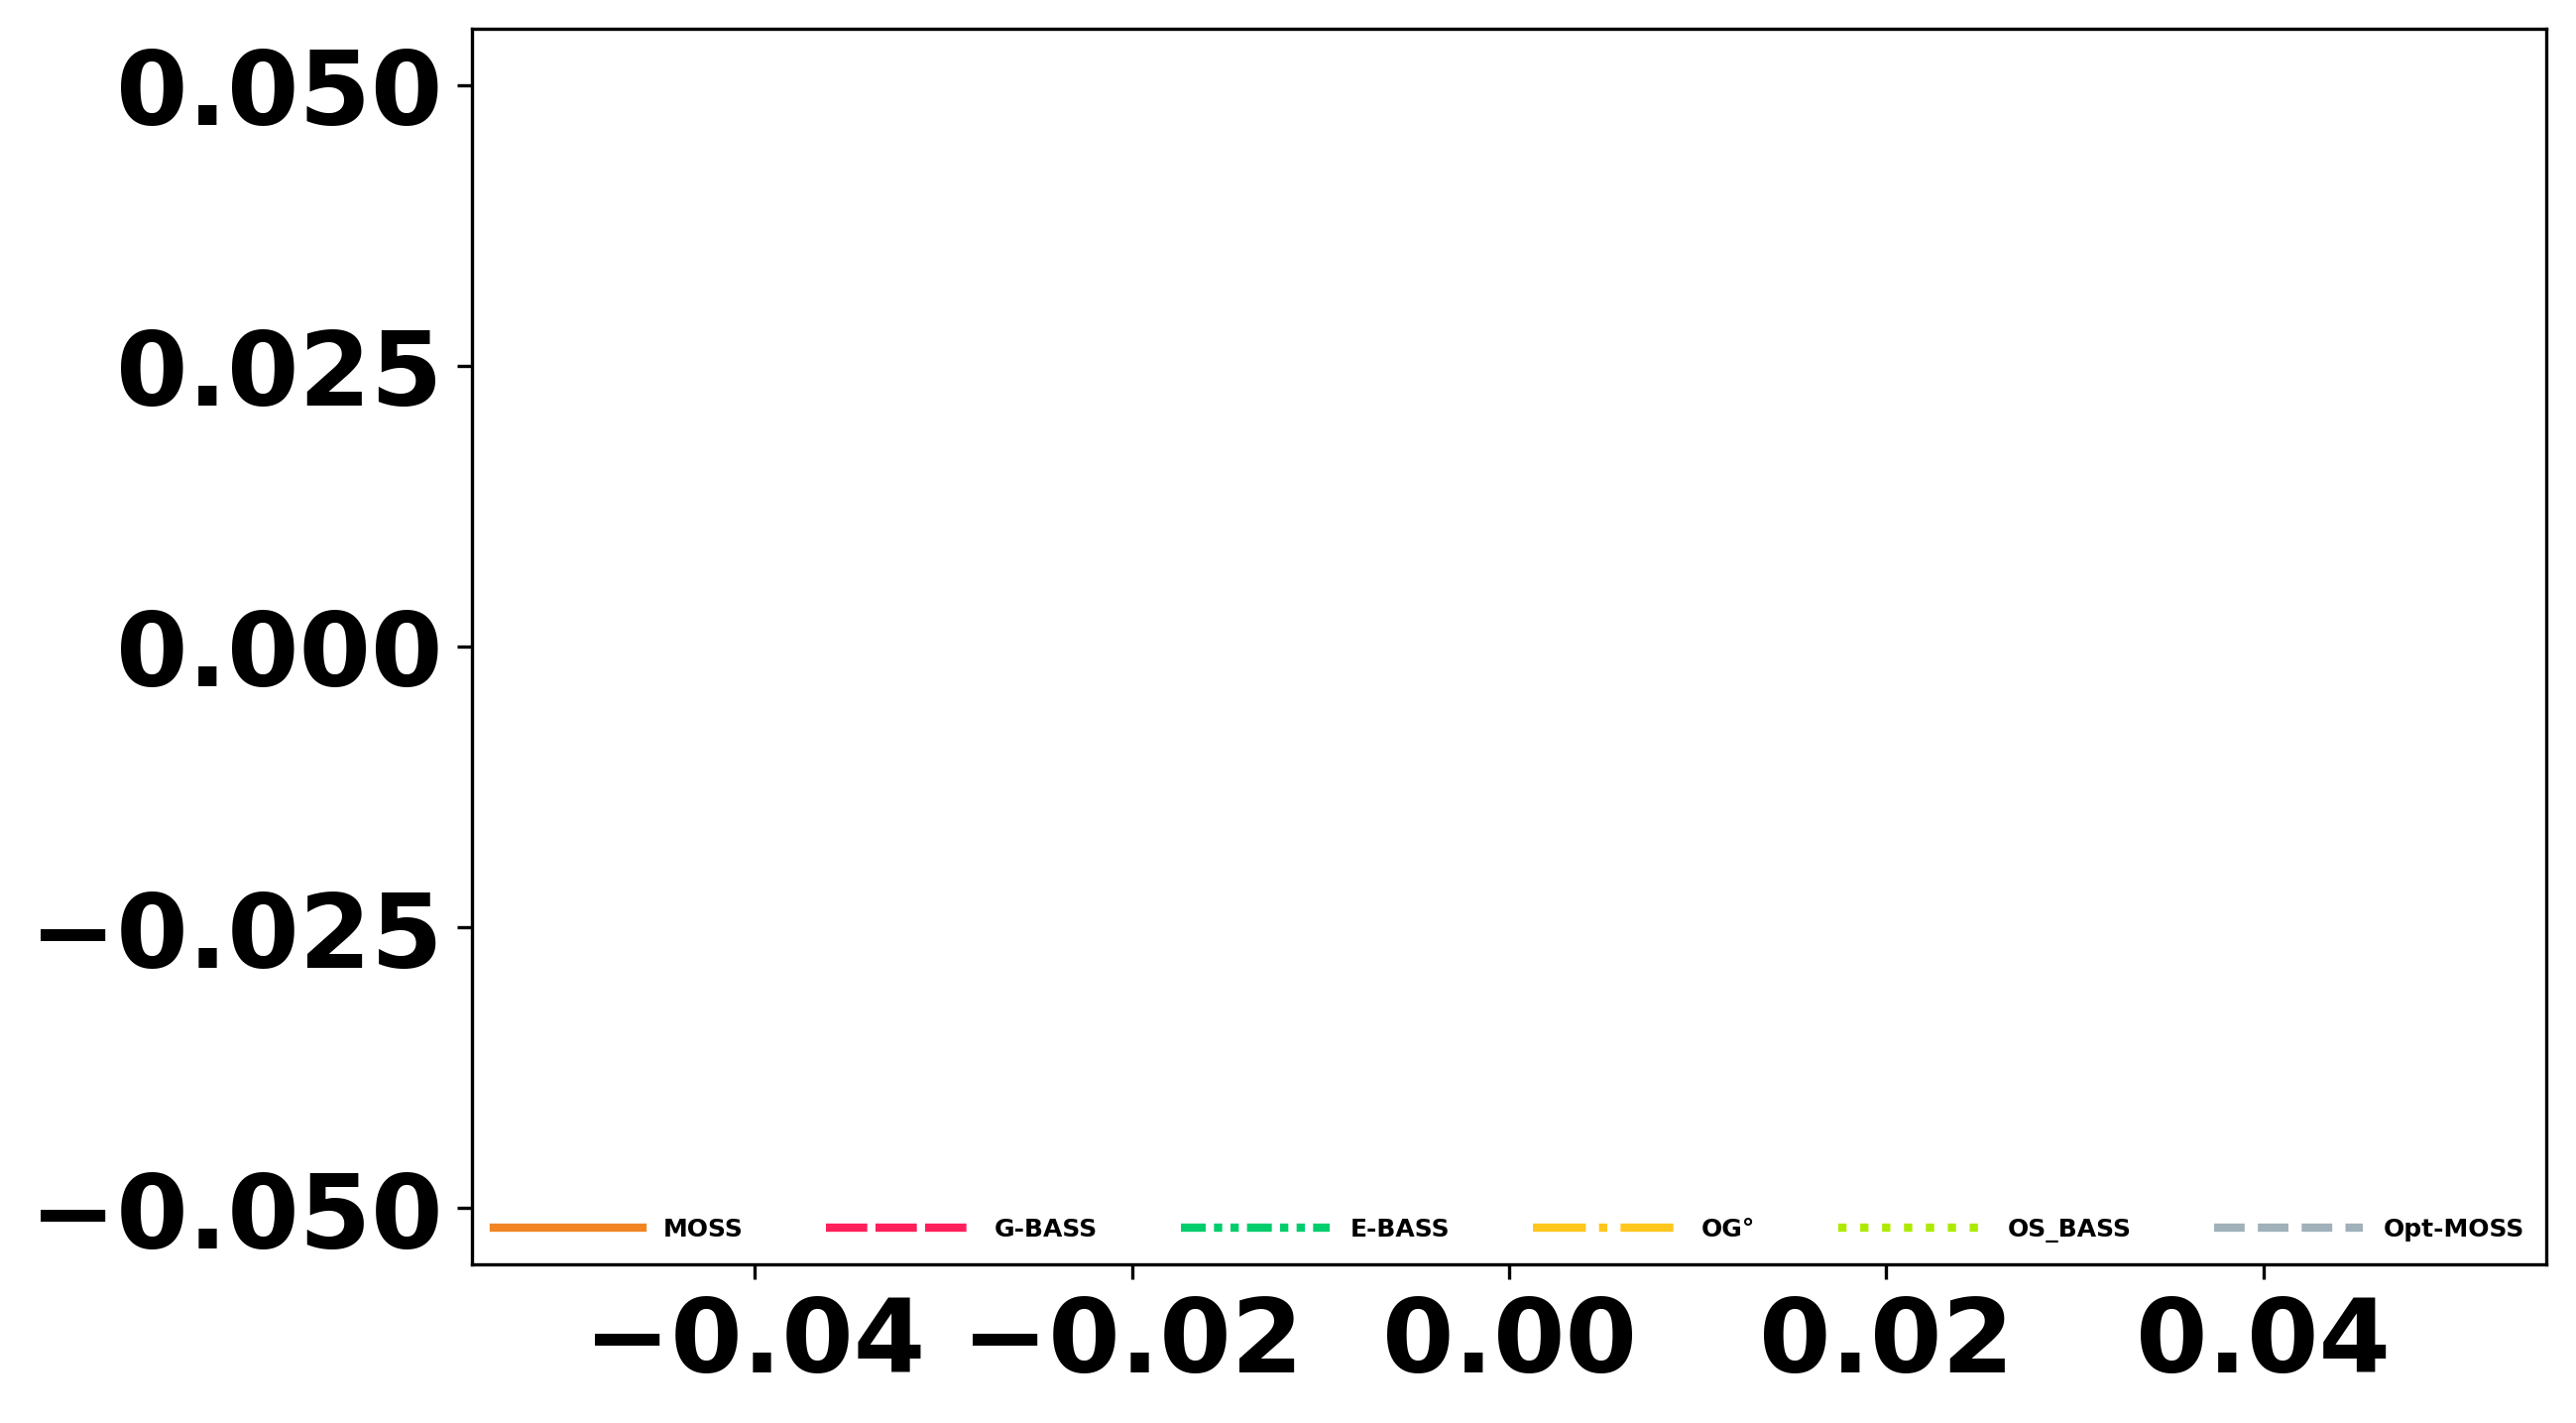

In [3]:
# # labels = ["MOSS", "G-BASS", "OG°", "OS-BASS", "Opt-MOSS"]
labels = ["MOSS", "G-BASS", "E-BASS", "OG°", "OS_BASS", "Opt-MOSS"]
# colors = ["#F28522", "#FF1F5B", "#FFC61E", "#AEEA00", "#A0B1BA"]
colors = ["#F28522", "#FF1F5B", "#00CD6C", "#FFC61E", "#AEEA00", "#A0B1BA"]
# linestyles = ["-", (0, (5, 1)), "-.", "dotted", "--" ]
linestyles = ["-", (0, (5, 1)), (0, (3,1,1,1,1, 1)), "-.", "dotted", "--"]
f = lambda c,l: plt.plot([],[], color=c, ls=l, linewidth=2)[0]
handles = [f(colors[i], linestyles[i]) for i in range(len(labels))]
legend = plt.legend(handles, labels, loc='lower left', framealpha=1, frameon=False, mode="expand", 
                    ncol=6, handlelength=6)

def export_legend(legend, filename="legend6.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()